In [ ]:
from google.colab import drive
# drive.mount('/content/drive/MyDrive/IITP/sohyun/creditcard_prediction/data')
drive.mount('/content/drive')

%cd drive/MyDrive/IITP/sohyun/TimeSeriesAnomaly/data/modify

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1j1N0u5t0l99N_wfSd5UZvnhugzn5g_NC/TimeSeriesAnomaly/data/modify


In [ ]:
!pip install orion-ml -qqq

     |████████████████████████████████| 117 kB 5.2 MB/s 
     |████████████████████████████████| 2.9 MB 46.1 MB/s 
     |████████████████████████████████| 3.1 MB 37.3 MB/s 
     |████████████████████████████████| 149 kB 45.2 MB/s 
     |████████████████████████████████| 394.5 MB 42 kB/s 
     |████████████████████████████████| 184 kB 71.5 MB/s 
     |████████████████████████████████| 2.5 MB 45.9 MB/s 
     |████████████████████████████████| 20.1 MB 77.2 MB/s 
     |████████████████████████████████| 85 kB 3.4 MB/s 
     |████████████████████████████████| 294 kB 69.4 MB/s 
     |████████████████████████████████| 310 kB 54.6 MB/s 
     |████████████████████████████████| 981 kB 53.4 MB/s 
     |████████████████████████████████| 41 kB 552 kB/s 
     |████████████████████████████████| 172 kB 62.3 MB/s 
     |████████████████████████████████| 24.6 MB 1.6 MB/s 
     |████████████████████████████████| 9.9 MB 32.7 MB/s 
     |████████████████████████████████| 127 kB 42.6 MB/s 
     |████████████

In [ ]:
# !pip install wandb -qqq
# import wandb
# wandb.login()

In [ ]:
import matplotlib.pyplot as plt
import easydict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
import time
import math

## Data 

In [ ]:
#---# LOAD npy file #---#
Fu_20_normal = np.load('Fu_20_normal.npy')
Fu_21_normal = np.load('Fu_21_normal.npy')
Fu_21_abnormal = np.load('Fu_21_abnormal.npy')
Fu_22_normal = np.load('Fu_22_normal.npy')
Fu_22_abnormal = np.load('Fu_22_abnormal.npy')

Fu_20_normal_10 = np.load('Fu_20_normal_10.npy')
Fu_21_normal_10 = np.load('Fu_21_normal_10.npy')
Fu_21_abnormal_10 = np.load('Fu_21_abnormal_10.npy')
Fu_22_normal_10 = np.load('Fu_22_normal_10.npy')
Fu_22_abnormal_10 = np.load('Fu_22_abnormal_10.npy')

# import sys
# np.set_printoptions(threshold=sys.maxsize) # print all

#---# 확인용 #---#
# plt.figure(figsize=(30,5))
# plt.plot(Fu_22_abnormal_10)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class MyDataset(Dataset):
  def __init__(self, data):
    self.data = np.array(self.sliding_window(data, config.window_size, config.stride))
    self.data = self.data.reshape(-1, config.window_size)
    
  def __getitem__(self, index):
    self.x = self.data[index]
    return (index, torch.Tensor(self.x))
      
  def __len__(self):
    return len(self.data)

  #---# Window #---#
  def sliding_window(self, arr, window_size, stride):
    start_pt = 0
    total_data = []
    while(True) :
      if len(arr) < (start_pt + window_size) : break
      data = arr[start_pt:start_pt+window_size]
      start_pt += stride
      total_data.append(data)
    return total_data


def sliding_window(arr, window_size, stride): ######### 중복
    start_pt = 0
    total_data = []
    while(True) :
      if len(arr) < (start_pt + window_size) : break
      data = arr[start_pt:start_pt+window_size]
      start_pt += stride
      total_data.append(data)
    return total_data

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore


def get_anomaly_time(original, prediction) : 
  temp = np.zeros(shape=(len(original),), dtype=np.float32)
  original = original.squeeze(axis = 1)

  for i in range(len(prediction)) :
    if prediction[i] == 0 :
      temp[i*config.stride : (i*config.stride + config.window_size)] = np.nan

    elif prediction[i] == 1 : # anomaly
      temp[i*config.stride : (i*config.stride + config.window_size)] = original[i*config.stride : (i*config.stride + config.window_size)]

  return temp


def drawing(pred, x) :
  #---# Drawing - 22 #---#
  plt.figure(figsize=(30,5))
  plt.plot(x, markersize=1)
  plt.plot(pred, marker='.', markersize=2, color='r', linestyle='None')

  '''
  for i in range(len(pred)):
    if pred[i] == 1:
      # plt.vlines(i * config.window_size, -1, 4, colors="y")
      # plt.vlines((i+1) * config.window_size, -1, 4, colors="y")
      before = i * config.window_size
      after = (i+1) * config.window_size

      r = np.linspace(before, after)
      plt.fill_between(r, -1, 4, color = "yellow", alpha = 0.5)
  '''

  #---# 실제 anomaly 값 구간 #---#
  a = np.linspace(62200, 65300)
  # plt.fill_between(a, 0, 2000, color='green', alpha=0.3)
  plt.fill_between(a, -1, 4, color='green', alpha=0.5)
  b = np.linspace(95600, 99300)
  # plt.fill_between(b, 0, 2000, color='green', alpha=0.5)
  plt.fill_between(b, -1, 4, color='green', alpha=0.5)
  c = np.linspace(148400, 152300)
  # plt.fill_between(c, 0, 2000, color='green', alpha=0.5)
  plt.fill_between(c, -1, 4, color='green', alpha=0.5)

  plt.show()
  plt.clf()

'''def calculate(true_list, pred_list) : 
  pred_list = pred_list.dropna()

  pred_anomaly_set = set(pred_list.index.tolist())
  pred_normal_set = set(range(len(true_list))) - pred_anomaly_set
  true_anomaly_set = set(np.where(np.array(true_list) != 0)[0].tolist())
  true_normal_set = set(np.where(np.array(true_list) == 0)[0].tolist())

  recall = len(pred_anomaly_set.intersection(true_anomaly_set)) / len(true_anomaly_set)
  # accuracy = len(anomaly_set.intersection(true_set)) / len(anomaly_set.union(true_set))
  accuracy = (len(pred_anomaly_set.intersection(true_anomaly_set)) + len(pred_normal_set.intersection(true_normal_set))) / len(true_list) # (빨간 거 맞은거 + 파란거 맞은거) / 전체
  return recall, accuracy'''

def calculate(true_list, pred_list): 
  pred_list = pred_list.dropna()

  pred_anomaly_set = set(pred_list.index.tolist())
  pred_normal_set = set(range(len(true_list))) - pred_anomaly_set
  true_anomaly_set = set(np.where(np.array(true_list) != 0)[0].tolist())
  true_normal_set = set(np.where(np.array(true_list) == 0)[0].tolist())

  recall = len(pred_anomaly_set.intersection(true_anomaly_set)) / len(true_anomaly_set)
  precision = len(pred_anomaly_set.intersection(true_anomaly_set)) / len(pred_anomaly_set.union(true_anomaly_set)) # len(anomaly_set.union(true_set))
  accuracy = (len(pred_anomaly_set.intersection(true_anomaly_set)) + len(pred_normal_set.intersection(true_normal_set))) / len(true_list) # (빨간 거 맞은거 + 파란거 맞은거) / 전체
  return recall, precision, accuracy

In [ ]:
config = easydict.EasyDict({
    "num_epochs" : 10, #500
    "batch_size" : 16, #16 
    "mode" : 'train',
    # "mode" : "test",
    "lr" : 1e-3, 
    "wd" : None,
    "window_size" : 1000,
    "stride" : 250,
    "threshold" : 0.3, # 0.3이나 0.2로 하기
    "seed" : 1004
})
seed_everything(config.seed)
tm = time.localtime(time.time())
string = time.strftime('%Y%m%d_%H%M%S', tm)

# wandb.init(project="Anomaly-Oil", entity="sohyun", name=string, magic=True)

train = pd.DataFrame(Fu_22_normal_10, columns=['Fu'])
train = pd.concat([train, pd.DataFrame(Fu_21_normal_10, columns=['Fu']), pd.DataFrame(Fu_20_normal_10, columns=['Fu'])], axis=0)
test = pd.DataFrame(Fu_22_abnormal_10, columns=['Fu'])
test_len = len(test)
total = pd.DataFrame(pd.concat([train, test], axis=0))

# train_scale = train['Fu'].values
# test_scale = test['Fu'].values
# total_scale = total['Fu'].values

#---# Noramlize #---#
scaler = StandardScaler()
total_scale = scaler.fit_transform(total); total_scale = pd.DataFrame(total_scale, columns=['Fu'])['Fu'].values.tolist() # total 먼저 해놓고 transform
train_scale = scaler.transform(train); train_scale = pd.DataFrame(train_scale, columns=['Fu'])['Fu'].values.tolist()
test_scale = scaler.transform(test); test_scale = pd.DataFrame(test_scale, columns=['Fu'])['Fu'].values.tolist()

# scaler = MinMaxScaler()
# total_scale = scaler.fit_transform(total); total_scale = pd.DataFrame(total_scale, columns=['Fu'])['Fu'].values.tolist()
# test_scale = scaler.transform(test); test_scale = pd.DataFrame(test_scale, columns=['Fu'])['Fu'].values.tolist()

#---# Setting train data #---# 나머지 끊어주어야 함
train_dataset1 = MyDataset(data=train_scale[:len(Fu_22_normal_10)])
train_dataset2 = MyDataset(data=train_scale[len(Fu_22_normal_10):(len(Fu_22_normal_10)+len(Fu_21_normal_10))])
train_dataset3 = MyDataset(data=train_scale[(len(Fu_22_normal_10)+len(Fu_21_normal_10)):])
train_dataset = np.concatenate([train_dataset1.data, train_dataset2.data, train_dataset3.data], axis = 0)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, drop_last=True)
test_dataset = MyDataset(data=test_scale)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)


# optimizer = torch.optim.Adam(params = model.parameters(), lr = config.lr) # lr = config.lr
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

##########################
#---# true list 만들기 #---#
##########################
true_label = [0 for i in range(len(test_scale))] # test_scale
true_label[62200:65300] = [1 for i in range(62200,65300)]
true_label[95600:99300] = [1 for i in range(95600,99300)]
true_label[148400:152300] = [1 for i in range(148400,152300)]

true_label_sliding = sliding_window(np.array(true_label), config.window_size, config.stride)
true_label_sliding = np.expand_dims(np.array(true_label_sliding), 2) # dimension expansion

In [ ]:
from pandas.tseries.offsets import Second
from datetime import date, timedelta
from orion import Orion
from datetime import datetime
from mlprimitives import load_primitive

def make_timestamp(date, data_len) :
  # start_date = datetime.strptime('201802210000', '%Y%m%d%H%M')
  start_date = datetime.strptime(date, '%Y%m%d%H%M')
  timestamp = time.mktime(start_date.timetuple())
  dates = []; dates.append(timestamp)

  for i in range(data_len-1) :
    new_start_date = start_date + timedelta(minutes=10)
    timestamp = time.mktime(new_start_date.timetuple())
    dates.append(timestamp)
    start_date = new_start_date
  
  return dates

dates = make_timestamp('201802210000', len(train_scale))
traindata = pd.DataFrame({"timestamp":dates, "value":train_scale})
dates_test = make_timestamp('201802211200', len(test_scale))
testdata = pd.DataFrame({"timestamp":dates_test, "value":test_scale})


In [ ]:
###################################
#---# Rolling window sequence #---#
###################################
'''
window_size 
target_size
step_size
target_column
drop_windows
'''
primitive = load_primitive('mlprimitives.custom.timeseries_preprocessing.rolling_window_sequences', 
                           arguments={'window_size':1000, 'target_size':0, 'step_size':250, 'target_column':0, 'drop_windows':False})
traindata = np.array(train_scale).reshape(-1, 1)
index = np.array(range(len(train_scale))).reshape(-1, 1)
X, y, index, target_index = primitive.produce(X=traindata, index=index)

testdata = np.array(test_scale).reshape(-1, 1)
index_test = np.array(range(len(test_scale))).reshape(-1, 1)
X_test, y_test, index_test, target_index_test = primitive.produce(X=testdata, index=index_test)

print(f"X shape = {X.shape}, y shape = {y.shape}, index shape = {index.shape}, target_index shape = {target_index.shape}")

X shape = (2447, 1000, 1), y shape = (2447, 0), index shape = (2447, 1), target_index shape = (2447, 1)


In [ ]:
testdata.shape

(233803, 1)

============== Dense AE ==============
Epoch 1/25
123/123 [==============================] - 1s 5ms/step - loss: 0.7491 - mse: 0.7491 - val_loss: 0.4739 - val_mse: 0.4739
Epoch 2/25
123/123 [==============================] - 0s 4ms/step - loss: 0.5503 - mse: 0.5503 - val_loss: 0.3532 - val_mse: 0.3532
Epoch 3/25
123/123 [==============================] - 0s 4ms/step - loss: 0.4603 - mse: 0.4603 - val_loss: 0.2644 - val_mse: 0.2644
Epoch 4/25
123/123 [==============================] - 0s 4ms/step - loss: 0.4537 - mse: 0.4537 - val_loss: 0.2410 - val_mse: 0.2410
Epoch 5/25
123/123 [==============================] - 0s 4ms/step - loss: 0.3835 - mse: 0.3835 - val_loss: 0.2379 - val_mse: 0.2379
Epoch 6/25
123/123 [==============================] - 0s 4ms/step - loss: 0.3822 - mse: 0.3822 - val_loss: 0.2210 - val_mse: 0.2210
Epoch 7/25
123/123 [==============================] - 0s 4ms/step - loss: 0.3801 - mse: 0.3801 - val_loss: 0.2111 - val_mse: 0.2111
Epoch 8/25
123/123 [=================

/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


===error_range===
 [[1.42000000e+02 1.52000000e+02 6.48057072e-01]
 [2.50000000e+02 2.59000000e+02 7.34605204e-01]
 [3.90000000e+02 3.95000000e+02 5.17974175e-01]
 [4.03000000e+02 4.19000000e+02 7.20914098e-01]
 [5.96000000e+02 6.10000000e+02 5.99257958e-01]]


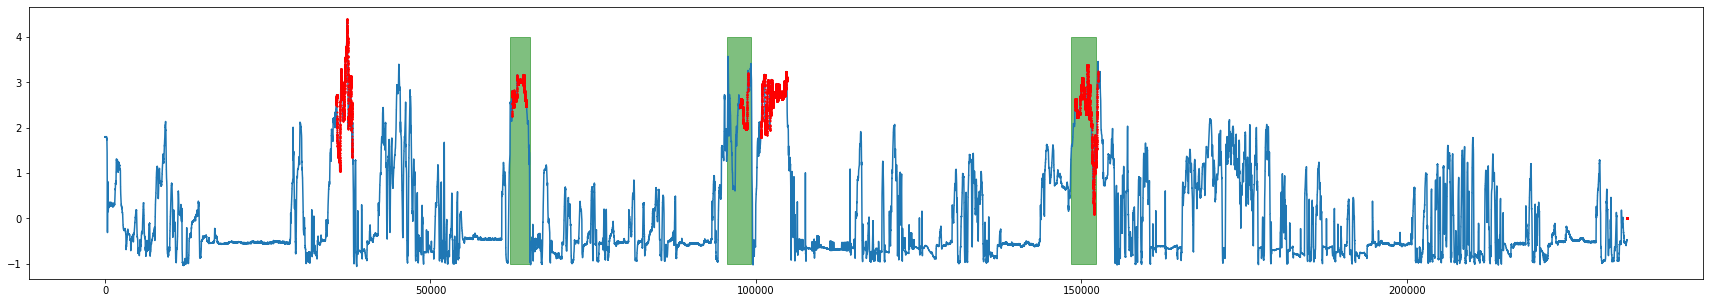

recall : 0.6355140186915887, accuracy : 0.9544359995380727, precision : 0.3896178307454306


<Figure size 432x288 with 0 Axes>

In [ ]:
#################
#---# ARIMA #---#
#################
'''
steps : number of forward steps to predict
p : the number of autoregressive parameters to use
d : the number of differences to use
q : the number of moving average (MA) parameters to use
'''

# primitive = load_primitive('statsmodels.tsa.arima_model.Arima',
#                            arguments = {"X":np.array(train_scale), "steps":1})
# y = primitive.produce(X=np.array(test_scale)) # predicted values
# print(y)

################
#---# LSTM #---#
################
'''
classification
epochs
callbacks
validation_split : default = 0.2
batch_size : default = 64
input_shape : 
dense_units : number of values ahead to predict (target size). default = 1
optimizer : default = keras.optimizers.Adam
loss : default = keras.mean_squared_error
metrics : defualt = ['mse']
return_seqeunces : whether to return the last output in the output sequence or the full sequence. default = False
layers : list of keras layers which are the basic building blocks
verbose : default = False
lstm_1_unit : dimensionality of the output space for the first LSTM layer. default = 80
dropout_1_rate : float(0~1) default = 0.3
lstm_2_unit
dropout_2_rate
'''
# kk = np.array(train_scale).reshape(1,-1,1)
# primitive = load_primitive('keras.Sequential.LSTMTimeSeriesRegressor',
#                            arguments = {"X":kk, "y":y, "batch_size":16, "validation_split":0.2}) #"input_shape":()
# primitive.fit()
# print(primitive.produce(X=X))


###################
#---# LSTM AE #---#
###################
# starttime = time.time()
# print("============== LSTM AE ==============")
# primitive = load_primitive('keras.Sequential.LSTMSeq2Seq',
#                           arguments = {'X':X, "y":X, "classification":False, 
#                                         "epochs":2,
#                                         "input_shape":(1000,1),
#                                         "target_shape":(1000,1),
#                                         "window_size":1000, "batch_size":8, 
#                                         "validation_split":0.2})
# primitive.fit()
# pred = primitive.produce(X=X_test)
# # pred.mean()

# primitive = load_primitive('orion.primitives.timeseries_errors.reconstruction_errors')
# errors, predictions = primitive.produce(y=X_test, y_hat=pred); print(errors.shape)

# primitive = load_primitive('orion.primitives.timeseries_anomalies.find_anomalies',
#                           arguments = {'anomaly_padding':1})
# error_range = primitive.produce(errors=errors, index=range(len(errors)))
# print("===error_range===\n", error_range)

# prediction = pd.DataFrame(0, index=range(0, len(X_test)), columns={'Fu'})
# for i in error_range :
#   start = int(i[0])
#   end = int(i[1])
#   prediction[start:end] = 1

# anomaly_value = get_anomaly_time(testdata, prediction['Fu'].values.tolist())
# drawing(anomaly_value, pd.DataFrame(testdata))
# recall, accuracy = calculate(pd.DataFrame(true_label), pd.DataFrame(anomaly_value))
# print(f'recall : {recall}, accuracy : {accuracy}')
# print("time : ", time.time() - starttime)

####################
#---# Dense AE #---#
####################
print("============== Dense AE ==============")
primitive = load_primitive('keras.Sequential.DenseSeq2Seq',
                           arguments = {'X':X, "y":X, "classification":False, 
                                        "epochs":25,
                                        "input_shape":(1000,1),
                                        "target_shape":(1000,1),
                                        "window_size":1000, "batch_size": 16, #16
                                        "validation_split":0.2})
primitive.fit()
pred = primitive.produce(X=X_test)
# pred.mean()

primitive = load_primitive('orion.primitives.timeseries_errors.reconstruction_errors')
errors, predictions = primitive.produce(y=X_test, y_hat=pred)

primitive = load_primitive('orion.primitives.timeseries_anomalies.find_anomalies',
                           arguments = {'anomaly_padding':1})
error_range = primitive.produce(errors=errors, index=range(len(errors)))
print("===error_range===\n", error_range)

prediction = pd.DataFrame(0, index=range(0, len(X_test)), columns={'Fu'})
for i in error_range :
  start = int(i[0])
  end = int(i[1])
  prediction[start:end] = 1

anomaly_value = get_anomaly_time(testdata, prediction['Fu'].values.tolist())
drawing(anomaly_value, pd.DataFrame(testdata))
# recall, accuracy = calculate(pd.DataFrame(true_label), pd.DataFrame(anomaly_value))
recall, precision, accuracy = calculate(pd.DataFrame(true_label), pd.DataFrame(anomaly_value))
print(f'recall : {recall}, accuracy : {accuracy}, precision : {precision}')


####################
#---# TadGAN #---#
####################
# from keras.layers import Input, Lambda, Dense
# import tensorflow as tf

# print("============== TadGAN ==============")
# primitive = load_primitive('orion.primitives.tadgan.TadGAN',
#                            arguments = {'X':X, "y":X, 
#                                         "epochs":15,
#                                         "input_shape":(1000,1),
#                                         "target_shape":(1000,1),
#                                         "latent_dim" : 100,
#                                         # "batch_size": 16, ########
#                                         "learning_rate" : 0.01,
#                                         "dense_units" : 100
#                                         })
# primitive.fit()

# pred, critic = primitive.produce(X=X_test, y=true_label_sliding)
# print(f'average reconstructed value:{y.mean()}, critic score:{critic[0][0]}')

# primitive = load_primitive('orion.primitives.tadgan.score_anomalies',
#                            arguments = {'error_smooth_window':10,
#                                         'critic_smooth_window':10,
#                                         'score_window':10,
#                                         'comb':'rec'})
# index = np.array([[1]])
# errors, true_index, true, predictions = primitive.produce(y=X_test, y_hat=pred, critic=critic, index=index)

# primitive = load_primitive('orion.primitives.timeseries_anomalies.find_anomalies',
#                            arguments = {'anomaly_padding':1})
# error_range = primitive.produce(errors=errors, index=range(len(errors)))
# print("=== error_range ===\n", error_range)

# prediction = pd.DataFrame(0, index=range(0, len(X_test)), columns={'Fu'})
# for i in error_range :
#   start = int(i[0])
#   end = int(i[1])
#   prediction[start:end] = 1

# anomaly_value = get_anomaly_time(testdata, prediction['Fu'].values.tolist())
# drawing(anomaly_value, pd.DataFrame(testdata))
# recall, accuracy = calculate(pd.DataFrame(true_label), pd.DataFrame(anomaly_value))
# print(f'recall : {recall}, accuracy : {accuracy}')

/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


===error_range===
 [[141.         153.           1.0071961 ]
 [249.         260.           1.09087033]
 [384.         421.           1.07016972]
 [595.         611.           0.92118334]]


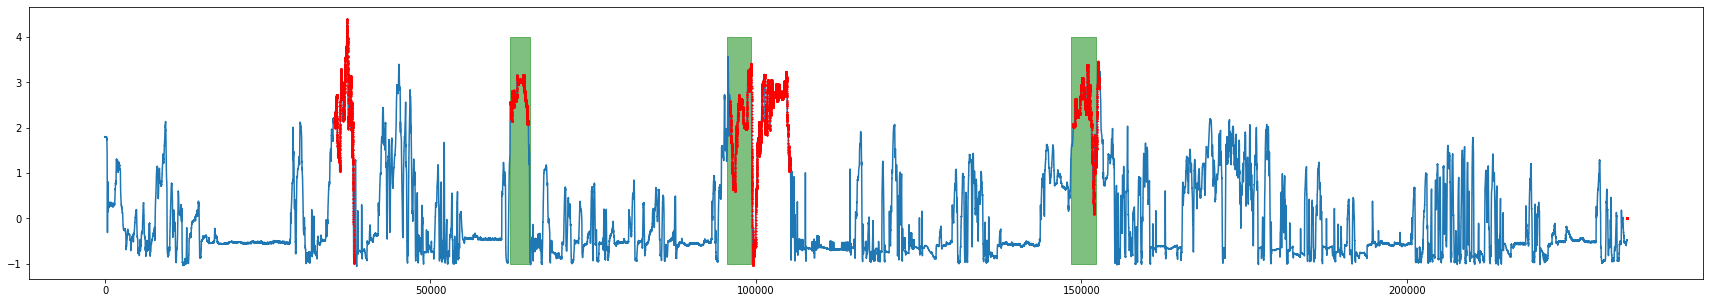

recall : 0.897196261682243, accuracy : 0.9548637100464922


<Figure size 432x288 with 0 Axes>

In [ ]:
###
primitive = load_primitive('orion.primitives.timeseries_anomalies.find_anomalies',
                          arguments = {'anomaly_padding':1})
error_range = primitive.produce(errors=errors, index=range(len(errors)))
print("===error_range===\n", error_range)

prediction = pd.DataFrame(0, index=range(0, len(X_test)), columns={'Fu'})
for i in error_range :
  start = int(i[0])
  end = int(i[1])
  prediction[start:end] = 1

anomaly_value = get_anomaly_time(testdata, prediction['Fu'].values.tolist())
drawing(anomaly_value, pd.DataFrame(testdata))
recall, accuracy = calculate(pd.DataFrame(true_label), pd.DataFrame(anomaly_value))
print(f'recall : {recall}, accuracy : {accuracy}')

In [ ]:
#---# TEST #---#
print(f"===========<{config.threshold}>===========")
config.threshold = 0.05; print(f"===========<{config.threshold}>===========")
pred, x, _x = trainer.test(test_loader, config.threshold)

def get_anomaly_time(original, prediction) : 
  temp = pd.DataFrame(index=range(0, len(original)), columns={'Fu'})
  # temp = temp.fillna(0)

  for i in range(len(prediction)) :
    if prediction[i] == 0 :
      for j in range(i*config.stride, (i*config.stride + config.window_size)) : 
        temp.loc[j] = np.nan

    elif prediction[i] == 1 : # anomaly
      for j in range(i*config.stride, (i*config.stride + config.window_size)) : 
        try : temp.loc[j] = original[j]
        except : pass

  # anomaly = temp.dropna()
  print(sum(pred))
  return temp

##########################
#---# true list 만들기 #---#
##########################
true_label = [0 for i in range(len(x))] # test_scale
true_label[62200:65300] = [1 for i in range(62200,65300)]
true_label[95600:99300] = [1 for i in range(95600,99300)]
true_label[148400:152300] = [1 for i in range(148400,152300)]

def calculate(true_list, pred_list) : ### 이따 수정 예정
  pred_list = pred_list.dropna()
  pred_anomaly_set = set(pred_list.index.tolist())
  pred_normal_set = set(range(len(true_list))) - pred_anomaly_set
  true_anomaly_set = set(np.where(np.array(true_list) == 1)[0].tolist())
  true_normal_set = set(np.where(np.array(true_list) == 0)[0].tolist())
  recall = len(pred_anomaly_set.intersection(true_anomaly_set)) / len(true_anomaly_set)
  # accuracy = len(anomaly_set.intersection(true_set)) / len(anomaly_set.union(true_set))

  accuracy = (len(pred_anomaly_set.intersection(true_anomaly_set)) + len(pred_normal_set.intersection(true_normal_set))) / len(true_list) # (빨간 거 맞은거 + 파란거 맞은거) / 전체
  return recall, accuracy

a = get_anomaly_time(x, pred)
recall, accuracy = calculate(true_label, a)

drawing(a, x, _x) # draw plot
print(f"===== RECALL ======\n{recall}\n====== ACCURACY =====\n{accuracy}")